### What is transfer learning and fine tune?

##### Transfer Learning:

Use pre-trained models on a new task.
Frozen base model layers (no weight updates).
Suitable when new dataset is small or similar to the original.
Focuses on training the custom classifier (top layers).

##### Fine-Tuning:
Unfreeze some or all pre-trained model layers.
Retrain the model with a lower learning rate.
Suitable when new dataset is large or significantly different.
Helps the model adapt better to the specific domain/task by updating earlier layers too.

##### What we will do in this notebook?
We have small dataset and we will use transfer learning to classify the Pistachio Nuts. We will use Resnet34 model for this task.

In [40]:
# # mount Google drive into colab
# from google.colab import drive
# drive.mount('/content/drive')


### How to download Kaggle Dataset

You need to obtain a Kaggle API key (kaggle.json) to download the dataset.
upload that json file to the colab environment. then you can use the following code to download the dataset:

In [41]:
# !chmod 600 ./kaggle.json

# !kaggle datasets download -d muratkokludataset/pistachio-image-dataset

# # Unzip the downloaded dataset
# !unzip pistachio-image-dataset.zip -d ./pistachio_dataset



In [42]:
## copy dataset to google drive (Optional)
# !cp ./pistachio-image-dataset.zip /content/drive/datasets/pistachio-image-dataset/

In [43]:
#!pip3 freeze > requirements.txt

### GPU Availability Check

In [44]:
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

In [45]:
import tensorflow as tf

# List available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Available GPU: {gpus[0]}")
else:
    print("No GPU found.")

Available GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [46]:
# Set the first GPU as the default
tf.config.set_visible_devices(gpus[0], 'GPU')

# Optionally, restrict TensorFlow to a specific amount of GPU memory
# Memory growth is useful to prevent TensorFlow from consuming all GPU memory
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### CNN Architecture
We are using ResNet34 architecture for this problem. ResNet34 is a variant of ResNet model which has 34 layers. It is pre-trained on ImageNet dataset. We will use transfer learning to fine-tune this model on our dataset. we will add a custom top layer to the model to make predictions on our dataset.

### Loading and Preprocessing the Data

In [47]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [48]:
data_dir = './pistachio_dataset/Pistachio_Image_Dataset/Pistachio_Image_Dataset/'
class_names = ['Kirmizi_Pistachio', 'Siirt_Pistachio']
print(class_names)

# Load the file names

dataset_files_names = []

for c in class_names:
    # list files using os library
    for filename in os.listdir(data_dir+c):
        file_path = os.path.join(data_dir+c, filename)

        # Check if the path is a file
        if os.path.isfile(file_path):

            # create the list of data points with class and file name
            dataset_files_names.append({
                'label': c,
                'file_name': file_path
            })

# Create a DataFrame
df = pd.DataFrame(dataset_files_names)

# shuffle the data
df = df.sample(frac=1,random_state=45).reset_index(drop=True)

# print each class count
print(df['label'].value_counts())

['Kirmizi_Pistachio', 'Siirt_Pistachio']
label
Kirmizi_Pistachio    1232
Siirt_Pistachio       916
Name: count, dtype: int64


In [49]:
# train, dev, test split
from sklearn.model_selection import train_test_split
random_state=42



# Split the data into train and test
df_train, df_test = train_test_split(df, test_size=0.2, random_state=random_state,shuffle=True)

# shuffle the df_train data with random state
df_train = df_train.sample(frac=1, random_state=random_state).reset_index(drop=True)


# Split the data into train and dev
df_test, df_dev = train_test_split(df_test, test_size=0.5, random_state=random_state)


### Dta distribution

In [50]:
print('Train:', df_train.shape[0])
print('Dev:', df_dev.shape[0])
print('Test:', df_test.shape[0])

print("Train:",df_train['label'].value_counts())
print("Dev:",df_dev['label'].value_counts())
print("Test:",df_test['label'].value_counts())

Train: 1718
Dev: 215
Test: 215
Train: label
Kirmizi_Pistachio    1001
Siirt_Pistachio       717
Name: count, dtype: int64
Dev: label
Kirmizi_Pistachio    112
Siirt_Pistachio      103
Name: count, dtype: int64
Test: label
Kirmizi_Pistachio    119
Siirt_Pistachio       96
Name: count, dtype: int64


### View some data

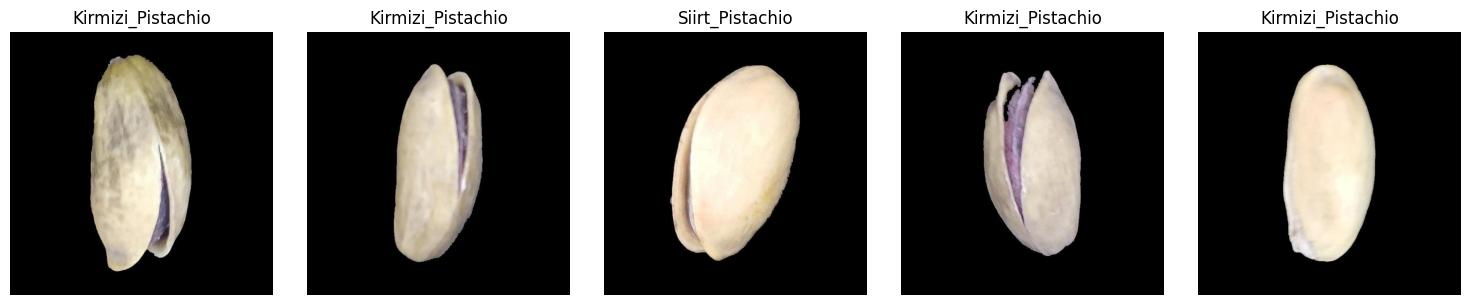

In [51]:
# load image using pil

def load_image(file_path,size=None):
    # Load image without resizing
    img = image.load_img(file_path)

    # Get the original dimensions of the image
    original_size = img.size  # (width, height)

    # Resize the image
    if size is not None:
        img = img.resize(size)

    # Convert image to numpy array
    img_array = image.img_to_array(img)
    return img_array, original_size


# Plotting 5 images in a row
plt.figure(figsize=(15, 3))  # Set the figure size (15x3 inches)

items =df_train.sample(5, random_state=55)
for i in range(5):
    plt.subplot(1, 5, i+1)  # 1 row, 5 columns, and plot index i+1
    dpoint = items.iloc[i]
    img, original_size = load_image(dpoint['file_name'])
    shape = img.shape

    # convert to uint8
    img = img.astype(np.uint8)

    plt.imshow(img)  # Show the image (assuming grayscale)
    plt.title(dpoint['label'])  # Set the class label as the title
    plt.axis('off')  # Hide the axis

# Display the images
plt.tight_layout()  # Adjust the spacing between the plots
plt.show()

### Data Augmentation and Batch Generation

In [52]:
# Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_datagen(rescale=1./255,is_training=True):
    if is_training:
        return ImageDataGenerator(
            rescale=rescale,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
    else:
        return ImageDataGenerator(rescale=rescale)

# Load an image
def batch_generator(data, batch_size, datagen, shuffle=True,input_dim_size=244,output_as_tensor=True):
    # Get the number of samples in the dataset
    n = data.shape[0]

    # Get the number of batches
    n_batches = n // batch_size

    # Generate batches
    while True:
        if shuffle:
            data = data.sample(frac=1).reset_index(drop=True)

        for i in range(n_batches):
            # Get the batch data
            batch_data = data.iloc[i*batch_size:(i+1)*batch_size]

            # Initialize the array for storing the images
            X_batch = np.empty((batch_size, input_dim_size, input_dim_size, 3))
            y_batch = np.empty((batch_size), dtype=int)

            # Load the images
            for j, (index, item) in enumerate(batch_data.iterrows()):
                img, _ = load_image(item['file_name'], size=(input_dim_size, input_dim_size))
                X_batch[j] = img

                y_batch[j] = class_names.index(item['label'])
                # print(y_batch[j])

            # Apply data augmentation
            X_batch = next(datagen.flow(X_batch, shuffle=False, batch_size=batch_size))

            if output_as_tensor == True:
              # convert to tensor for better performance
              yield tf.convert_to_tensor(X_batch), tf.convert_to_tensor(y_batch)
            else:
              yield X_batch, y_batch

### Show augmented images

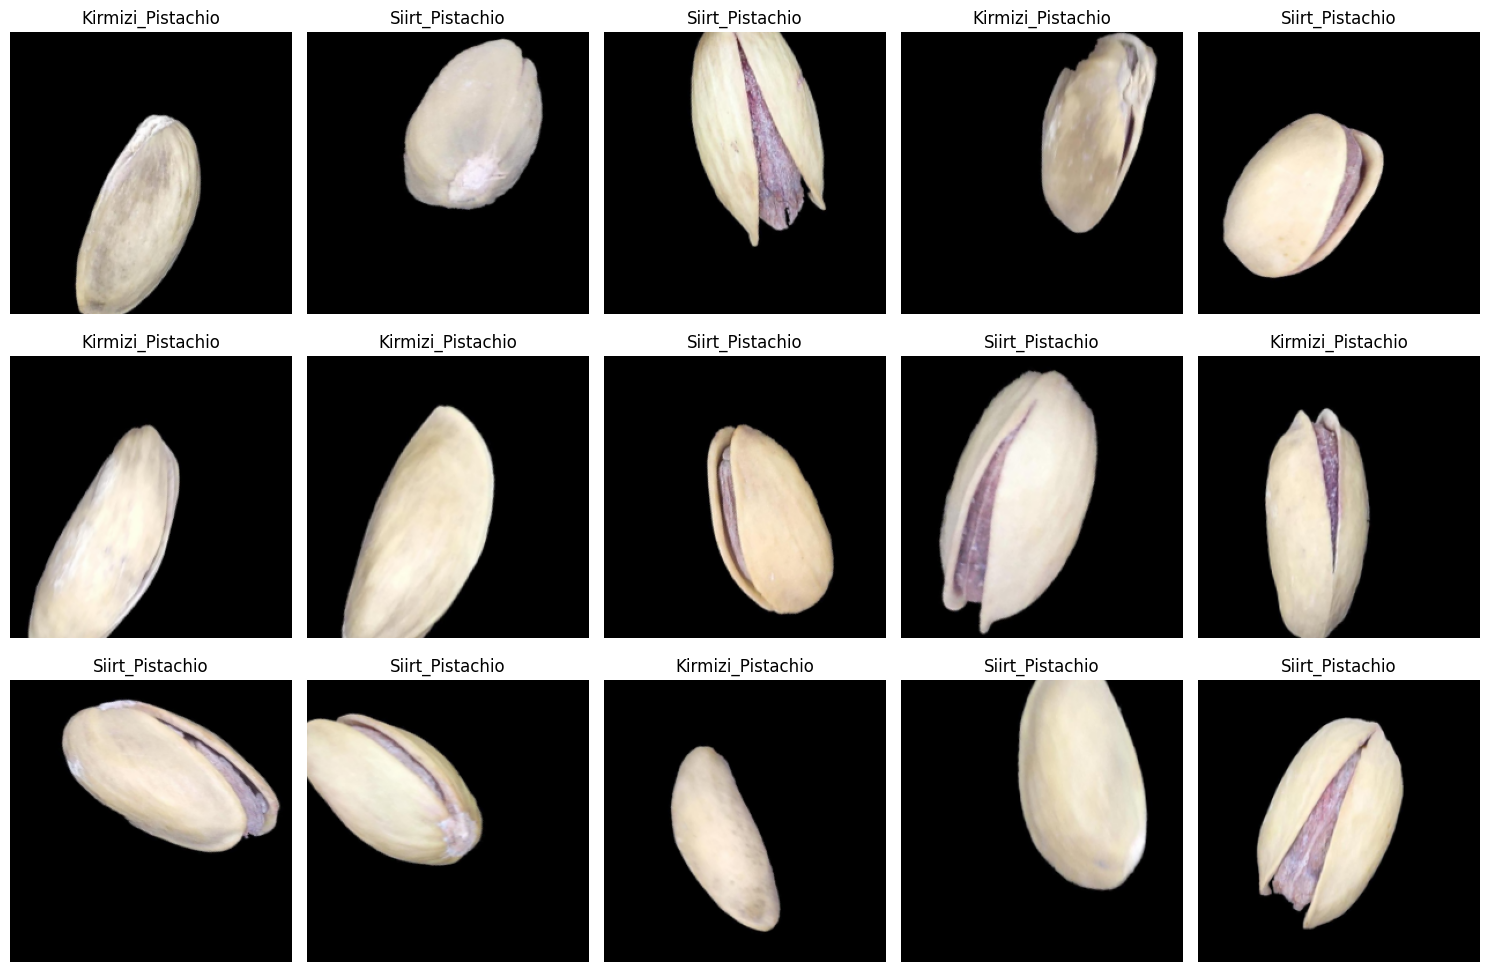

In [53]:
# using that batchgen  function  generate one batch of data and plot it
batch_size = 15
gen = batch_generator(df_train, batch_size, create_datagen(1),output_as_tensor=False)

# Plotting augmented images
X_batch, Y_batch = next(gen)

plt.figure(figsize=(15, 10))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    img = X_batch[i].astype(np.uint8)
    plt.imshow(img)
    plt.title(class_names[int(Y_batch[i])])
    plt.axis('off')
plt.tight_layout()
plt.show()


### Binary Classification Model

We have only two classee Kirmizi and Siirt. So we will use binary classification model.

In [54]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator




def create_model(input_shape):
    # Load the pre-trained ResNet34 model without the top layers
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Add new top layers for binary classification
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    # Create the new model
    model = Model(inputs=base_model.input, outputs=output)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    return model


In [55]:
batch_size = 32  # Batch size
num_classes = len(class_names)  # Number of classes
input_shape = (400, 400, 3)

# Create the data generator with pixel normalization
datagen_train = create_datagen(1./255,is_training=True)
datagen_val = create_datagen(1./255,is_training=False)

# Create the batch generator
gen = batch_generator(df_train, batch_size, datagen_train,True,input_dim_size=input_shape[0])
val_gen = batch_generator(df_dev, batch_size, datagen_val,False,input_dim_size=input_shape[0])

# Create the model
model = create_model(input_shape)


# print summary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 400, 400, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 406, 406, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 200, 200, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 202, 202, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 100, 100, 64)   │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 100, 100, 64)   │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 100, 100, 64)   │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 100, 100, 64)   │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 100, 100, 64)   │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 100, 100, 64)   │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 102, 102, 64)   │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 100, 100, 64)   │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 100, 100, 64)   │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 100, 100, 64)   │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 25,664,001 (97.90 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

#### Accuracy CallBack
When accuracy reach our expactation model trainig will be stop

In [56]:
class AccuracyEpochCallback(tf.keras.callbacks.Callback):
    def __init__(self, accuracy_threshold=0.96, epoch_threshold=8):
        super(AccuracyEpochCallback, self).__init__()
        self.accuracy_threshold = accuracy_threshold
        self.epoch_threshold = epoch_threshold

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get('accuracy')
        if current_accuracy is None:
            current_accuracy = logs.get('acc')  # For older versions of Keras

        if current_accuracy is None:
            raise ValueError("Accuracy is not being tracked. Make sure 'accuracy' is in your model's metrics.")

        if current_accuracy > self.accuracy_threshold and epoch + 1 > self.epoch_threshold:
            print(f"\nReached {current_accuracy:.4f} accuracy on epoch {epoch + 1}. Stopping training.")
            self.model.stop_training = True

### Training Model

In [57]:
from keras.callbacks import ModelCheckpoint

epochs = 15  # Number of epochs

# Compile the model
# adam optimizer use for optimization
# adam optmizer also use default as mini batch gradient descent
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using the generator and capture the history
steps_per_epoch = len(df_train) // batch_size
validation_steps = int(np.ceil(len(df_dev) / batch_size))

# each epoch end check the validation loss and save the model with best validation loss .
# if the validation loss is less than previous validation loss then save the model
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

acc_callback = AccuracyEpochCallback(accuracy_threshold=0.96, epoch_threshold=8)


history = model.fit(gen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=val_gen,
                    validation_steps=validation_steps,
                    callbacks=[checkpoint,acc_callback],
                    )

Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.6888 - loss: 0.5536 - val_accuracy: 0.9554 - val_loss: 0.2355
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.9043 - loss: 0.2640 - val_accuracy: 0.9732 - val_loss: 0.1646
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.9284 - loss: 0.1991 - val_accuracy: 0.9732 - val_loss: 0.1237
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.9369 - loss: 0.1780 - val_accuracy: 0.9420 - val_loss: 0.1392
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9680 - loss: 0.1249 - val_accuracy: 0.9732 - val_loss: 0.1004
Epoch 6/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9565 - loss: 0.1313 - val_accuracy: 0.9688 - val_loss: 0.0913
Epoch 7/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9599 - loss: 0.1217 - val_accuracy: 0.9643 - val_loss: 0.0955
Epoch 8/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.9524 - loss: 0.1171 - val_accuracy: 0.9777 - val_los

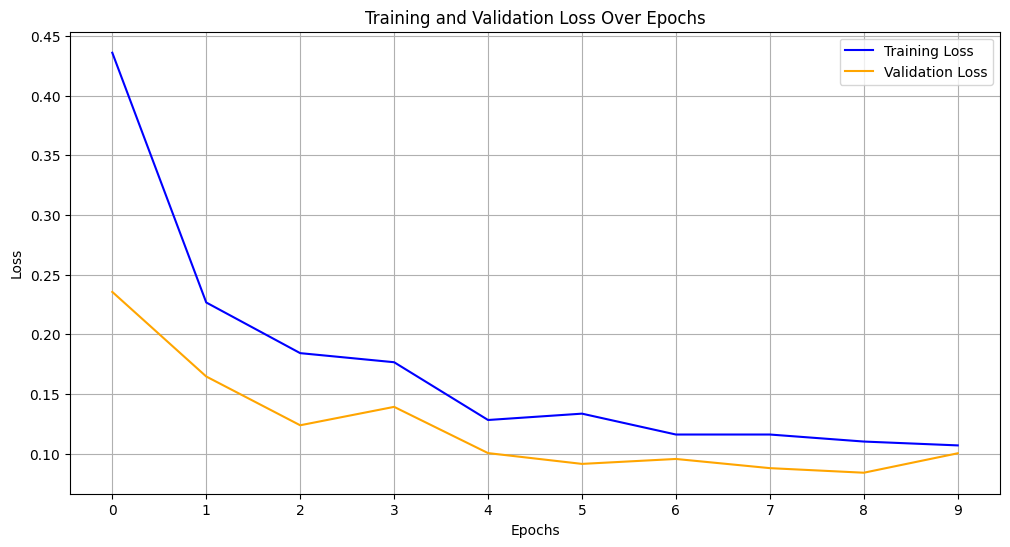

In [58]:
# Extract loss values
train_loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

# Plotting the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss_values, label='Training Loss', color='blue')
plt.plot(val_loss_values, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(len(train_loss_values)))  # Set x-ticks to match epochs
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Function to plot filters of a given layer
def plot_conv_filters(model, layer_num):
    # Extract the filters of the specified convolutional layer
    layer = model.layers[layer_num]

    # Check if the layer is a convolutional layer
    if 'conv' not in layer.name:
        print(f'Layer {layer_num} is not a convolutional layer.')
        return

    filters, biases = layer.get_weights()
    print(f"Shape of filters in layer {layer_num}: {filters.shape}")  # Shape: (filter_height, filter_width, input_depth, num_filters)

    # Normalize filter values to 0-1 for visualization
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)

    # Number of filters
    n_filters = filters.shape[-1]

    # Plotting each filter
    fig, axs = plt.subplots(1, n_filters, figsize=(n_filters, 1))

    for i in range(n_filters):
        # Extract the ith filter, selecting only the first channel for visualization
        f = filters[:, :, :, i]  # (height, width, input_depth)

        # Plot each filter, using only the first channel (for RGB input)
        axs[i].imshow(f[:, :, 0], cmap='viridis')
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function for a specific layer number (e.g., first convolutional layer)
plot_conv_filters(model, 1)  # Replace '1' with the desired layer number

In [ ]:
plot_conv_filters(model, 7)  # Replace '1' with the desired layer number


### Save model


In [60]:
model.save_weights('my_model.weights.h5')
with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


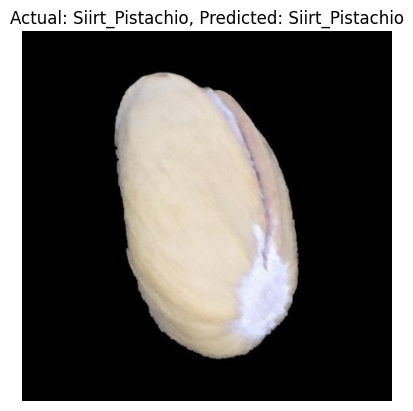

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


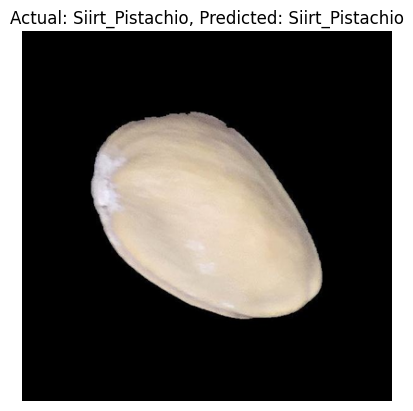

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


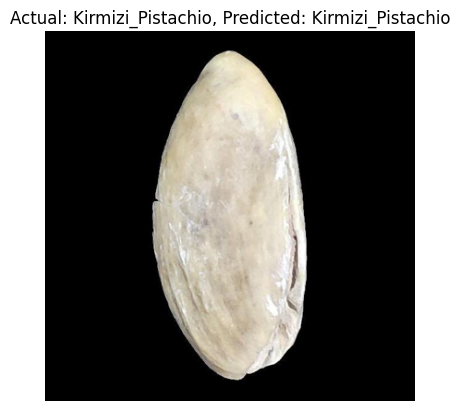

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


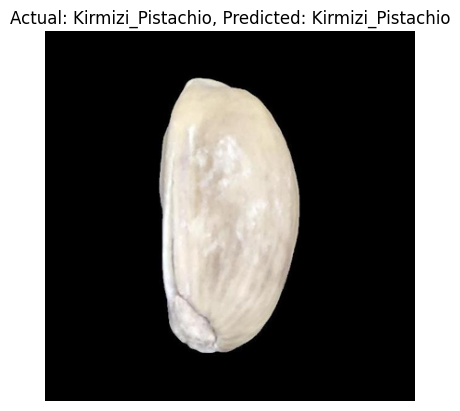

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


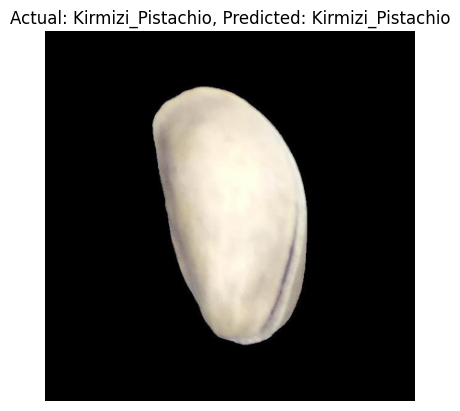

In [61]:
# predict the test data

items = df_test.sample(5, random_state=55)

for i in range(5):
    dpoint = items.iloc[i]
    img, _ = load_image(dpoint['file_name'], size=(input_shape[0], input_shape[1]))
    img = img.astype(np.uint8)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0
    pred = model.predict(img)
    pred_class = class_names[0] if pred[0] < 0.5 else class_names[1]
    plt.imshow(img[0])
    plt.title(f'Actual: {dpoint["label"]}, Predicted: {pred_class}')
    plt.axis('off')
    plt.show()

In [63]:
# Evaluate the model on the test data
test_gen = batch_generator(df_test, batch_size, datagen_val,False,input_dim_size=input_shape[0])

# Evaluate the model on the test data
results = model.evaluate(test_gen, steps=validation_steps)

# Print all evaluation results
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 528ms/step - accuracy: 0.9603 - loss: 0.1010
Test Loss: 0.0931
Test Accuracy: 0.9688


### Conclusion

In this notebook, we successfully developed a CNN model using Keras to classify Kirmizi and Siirt pistachio nuts. The model achieved high accuracy and demonstrated its ability to distinguish between the two classes effectively. This project showcases the power of CNNs and transfer learning in automating image classification tasks and highlights their potential applications in the agricultural sector for quality control and crop classification.

